# Demonstrate zarr-ification of CESM-LE

In [1]:
%matplotlib inline
import os
import shutil

import yaml

import xarray as xr

import intake
import intake_esm

import matplotlib.pyplot as plt

/glade/work/abanihi/softwares/miniconda3/envs/analysis/lib/python3.7/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)
/glade/work/abanihi/softwares/miniconda3/envs/analysis/lib/python3.7/site-packages/docrep/__init__.py:341: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  s = dedents('\n' + '\n'.join(lines[first:]))


## Spinup cluster

In [2]:
from ncar_jobqueue import NCARCluster
cluster = NCARCluster(memory="70GB")
#cluster.scale(10)  # Ask for 4 x 9 workers
cluster

/glade/work/abanihi/softwares/miniconda3/envs/analysis/lib/python3.7/site-packages/dask_jobqueue/config.py:12: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)
/glade/work/abanihi/softwares/miniconda3/envs/analysis/lib/python3.7/site-packages/distributed/deploy/local.py:138: UserWarning: diagnostics_port has been deprecated. Please use `dashboard_address=` instead
  "diagnostics_port has been deprecated. "


In [3]:
cluster.adapt(minimum=0, maximum=20, wait_count=60)

In [4]:
from dask.distributed import Client
client = Client(cluster) # Connect this local process to remote workers
client

Client Scheduler: tcp://10.12.203.5:46427 Dashboard: https://jupyterhub.ucar.edu/ch/user/abanihi/proxy/8787/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


## Connect to intake-esm database

In [5]:
col = intake.open_esm_metadatastore(collection_name='CESM1-LE')
col.df.head()

,resource,resource_type,direct_access,experiment,case,component,stream,variable,date_range,member_id,file_fullpath,file_basename,file_dirname,ctrl_branch_year,year_offset,sequence_order,has_ocean_bgc,grid
0,CTRL:GLADE:posix:/glade/collections/cdg/data/c...,posix,True,CTRL,b.e11.B1850C5CN.f09_g16.005,atm,cam.h1,T200,18000101-18991231,0,/glade/collections/cdg/data/cesmLE/CESM-CAM5-B...,b.e11.B1850C5CN.f09_g16.005.cam.h1.T200.180001...,/glade/collections/cdg/data/cesmLE/CESM-CAM5-B...,NaN,1448.0,0,True,NaN
1,CTRL:GLADE:posix:/glade/collections/cdg/data/c...,posix,True,CTRL,b.e11.B1850C5CN.f09_g16.005,atm,cam.h1,T200,08000101-08991231,0,/glade/collections/cdg/data/cesmLE/CESM-CAM5-B...,b.e11.B1850C5CN.f09_g16.005.cam.h1.T200.080001...,/glade/collections/cdg/data/cesmLE/CESM-CAM5-B...,NaN,1448.0,0,True,NaN
2,CTRL:GLADE:posix:/glade/collections/cdg/data/c...,posix,True,CTRL,b.e11.B1850C5CN.f09_g16.005,atm,cam.h1,T200,04020101-04991231,0,/glade/collections/cdg/data/cesmLE/CESM-CAM5-B...,b.e11.B1850C5CN.f09_g16.005.cam.h1.T200.040201...,/glade/collections/cdg/data/cesmLE/CESM-CAM5-B...,NaN,1448.0,0,True,NaN
3,CTRL:GLADE:posix:/glade/collections/cdg/data/c...,posix,True,CTRL,b.e11.B1850C5CN.f09_g16.005,atm,cam.h1,T200,10000101-10991231,0,/glade/collections/cdg/data/cesmLE/CESM-CAM5-B...,b.e11.B1850C5CN.f09_g16.005.cam.h1.T200.100001...,/glade/collections/cdg/data/cesmLE/CESM-CAM5-B...,NaN,1448.0,0,True,NaN
4,CTRL:GLADE:posix:/glade/collections/cdg/data/c...,posix,True,CTRL,b.e11.B1850C5CN.f09_g16.005,atm,cam.h1,T200,11000101-11991231,0,/glade/collections/cdg/data/cesmLE/CESM-CAM5-B...,b.e11.B1850C5CN.f09_g16.005.cam.h1.T200.110001...,/glade/collections/cdg/data/cesmLE/CESM-CAM5-B...,NaN,1448.0,0,True,NaN


In [6]:
def collection_summary(col):
    df = col.df
    print("There are:\n")
    print(f"\t1) {df.experiment.nunique()} experiments: \n\n\t\t{df.experiment.unique()}\n")
    print(f"\t2) {df.case.nunique()} cases: \n\n\t\t{df.case.unique()[:5]} etc...\n")
    print(f"\t3) {df.component.nunique()} components: \n\n\t\t{df.component.unique()}\n")
    print(f"\t4) {df.stream.nunique()} streams: \n\n\t\t{df.stream.unique()}\n")
    print(f"\t5) {df.variable.nunique()} variables: \n\n\t\t{df.variable.unique()[:10]} etc...\n")
    
collection_summary(col)

There are:

	1) 6 experiments: 

		['CTRL' 'CTRL-AMIP' 'CTRL-SLAB-OCN' '20C' '20C-OIC' 'RCP85']

	2) 93 cases: 

		['b.e11.B1850C5CN.f09_g16.005' 'f.e11.F1850C5CN.f09_f09.001'
 'e.e11.E1850C5CN.f09_g16.001' 'b.e11.B20TRC5CNBDRD.f09_g16.105'
 'b.e11.B20TRC5CNBDRD.f09_g16.104'] etc...

	3) 5 components: 

		['atm' 'ocn' 'lnd' 'rof' 'ice']

	4) 10 streams: 

		['cam.h1' 'cam.h0' 'pop.h.nday1' 'pop.h' 'clm2.h1' 'clm2.h0' 'rtm.h1'
 'rtm.h0' 'cice.h1' 'cice.h']

	5) 985 variables: 

		['T200' 'Q200' 'FLNSC' 'Q500' 'PRECL' 'QBOT' 'TREFHTMN' 'FSNTOA' 'TAUX'
 'TAUY'] etc...



## Specify process attributes

In [7]:
component_list = ['ocn']

experiment_list = ['20C', 'RCP85']

In [13]:
with open("../chunking_spec.yaml") as f:
    chunking_spec = yaml.safe_load(f)
chunking_spec

{'ocn': {'pop.h': {'time': 12, 'z_t': 20, 'nlat': 128, 'nlon': 80}},
 'ice': {'cice.h': {'time': 12}},
 'atm': {'cam.h0': {'time': 12}},
 'lnd': {'clm2.h0': {'time': 12}, 'clm2.h1': {'time': 30}}}

In [12]:
360/12

30.0

In [11]:
360/12



chunking_spec = yaml.safe_load('''
ocn:
  time: 12
  z_t: 10
  
atm:
  time: 12
''')

# vars to operate on
variable_request = yaml.safe_load('''
ocn:
  pop.h:
    - MOC
    - SHF
    - TEMP
atm:
  cam.h0:
    - T
    - U
''')
    

# file namer
dirout = '/glade/scratch/abanihi/calcs'
def zarr_file(exp, cmp, stream, var, write=False):
    path = f'{dirout}/CESM-LE-{exp}-{cmp}-{stream}-{var}.zarr'    
    if write and os.path.exists(path):
        shutil.rmtree(path)
    print(path)
    return path       

## Make `zarr` collection

In [33]:
# loop over experiments
for exp in experiment_list:
    
    # loop over model components
    for cmp in component_list:
        

        # set open_dataset keyword args
        xr_open = dict(chunks=chunking_spec[cmp], decode_times=False, decode_coords=False)

        # loop over streams
        for stm, varlist in variable_request[cmp].items():            

            # get the data
            for var in varlist:

                query = dict(experiment=exp, variable=var, stream=stm)            
                dd = col.search(**query).to_xarray(**xr_open)
                _, ds = dd.popitem()

                # apply subsetting in time
                # for proof of concept select only 3 years 
                # assuming monthly
                ds = ds.isel(time=slice(0, 36))

                # write a zarr file
                ds.to_zarr(zarr_file(exp, cmp, stm, var, write=True), consolidated=True)

/glade/scratch/abanihi/calcs/CESM-LE-20C-ocn-pop.h-O2.zarr


/glade/scratch/abanihi/calcs/CESM-LE-20C-ocn-pop.h-MOC.zarr


/glade/scratch/abanihi/calcs/CESM-LE-20C-ocn-pop.h-SHF.zarr


/glade/scratch/abanihi/calcs/CESM-LE-20C-ocn-pop.h-TEMP.zarr


## Read it back in to demonstrate merge

If we build a data catalog for the `zarr` collection, the reference to actually paths would go away. This is for illustration purposes only.

In [35]:
ds = xr.Dataset()
for var in ['SHF', 'TEMP',]:
    dsi = xr.open_zarr(zarr_file('20C', 'ocn', 'pop.h', var), consolidated=True, decode_times=False)
    ds = xr.merge((ds, dsi))
ds.info()    

/glade/scratch/abanihi/calcs/CESM-LE-20C-ocn-pop.h-SHF.zarr
/glade/scratch/abanihi/calcs/CESM-LE-20C-ocn-pop.h-TEMP.zarr
xarray.Dataset {
dimensions:
	d2 = 2 ;
	lat_aux_grid = 395 ;
	member_id = 40 ;
	moc_comp = 3 ;
	moc_z = 61 ;
	nlat = 384 ;
	nlon = 320 ;
	time = 36 ;
	transport_comp = 5 ;
	transport_reg = 2 ;
	z_t = 60 ;
	z_t_150m = 15 ;
	z_w = 60 ;
	z_w_bot = 60 ;
	z_w_top = 60 ;

variables:
	float64 ANGLE(member_id, nlat, nlon) ;
		ANGLE:long_name = angle grid makes with latitude line ;
		ANGLE:units = radians ;
	float64 ANGLET(member_id, nlat, nlon) ;
		ANGLET:long_name = angle grid makes with latitude line on T grid ;
		ANGLET:units = radians ;
	float64 DXT(member_id, nlat, nlon) ;
		DXT:long_name = x-spacing centered at T points ;
		DXT:units = centimeters ;
	float64 DXU(member_id, nlat, nlon) ;
		DXU:long_name = x-spacing centered at U points ;
		DXU:units = centimeters ;
	float64 DYT(member_id, nlat, nlon) ;
		DYT:long_name = y-spacing centered at T points ;
		DYT:units = cen

In [25]:
ds = xr.Dataset()
d = []
    for var in ['SHF', 'TEMP']:
        dsi = xr.open_zarr(zarr_file('20C', 'ocn', 'pop.h', case, var), decode_times=False)
        
        try:
            print(dsi.SHF.data.compute())
            print(ds.SHF.data.compute())
        except:
            pass
        d.append(dsi)
        ds = xr.merge((ds, dsi))
ds.info()                       

/glade/scratch/abanihi/calcs/CESM-LE-20C-ocn-pop.h-b.e11.B20TRC5CNBDRD.f09_g16.002-SHF.zarr
[[[         nan          nan          nan ...          nan          nan
            nan]
  [         nan          nan          nan ...          nan          nan
            nan]
  [  79.4123     123.52784    138.13007   ...          nan          nan
            nan]
  ...
  [         nan          nan          nan ...          nan          nan
            nan]
  [         nan          nan          nan ...          nan          nan
            nan]
  [         nan          nan          nan ...          nan          nan
            nan]]

 [[         nan          nan          nan ...          nan          nan
            nan]
  [         nan          nan          nan ...          nan          nan
            nan]
  [-194.75725   -179.18614   -159.89061   ...          nan          nan
            nan]
  ...
  [         nan          nan          nan ...          nan          nan
            nan]
  [ 

MergeError: conflicting values for variable 'SHF' on objects to be combined:
first value: <xarray.Variable (time: 36, nlat: 384, nlon: 320)>
dask.array<shape=(36, 384, 320), dtype=float32, chunksize=(12, 384, 320)>
Attributes:
    cell_methods:  time: mean
    grid_loc:      2110
    long_name:     Total Surface Heat Flux, Including SW
    units:         watt/m^2
second value: <xarray.Variable (time: 36, nlat: 384, nlon: 320)>
dask.array<shape=(36, 384, 320), dtype=float32, chunksize=(12, 384, 320)>
Attributes:
    cell_methods:  time: mean
    grid_loc:      2110
    long_name:     Total Surface Heat Flux, Including SW
    units:         watt/m^2

In [25]:
ds

<xarray.Dataset>
Dimensions:               (d2: 2, lat_aux_grid: 395, member_id: 40, moc_comp: 3, moc_z: 61, nlat: 384, nlon: 320, time: 36, transport_comp: 5, transport_reg: 2, z_t: 60, z_t_150m: 15, z_w: 60, z_w_bot: 60, z_w_top: 60)
Coordinates:
  * member_id             (member_id) int64 1 2 3 4 5 6 ... 101 102 103 104 105
  * lat_aux_grid          (lat_aux_grid) float32 -79.48815 -78.952896 ... 90.0
  * moc_z                 (moc_z) float32 0.0 1000.0 ... 525000.94 549999.06
  * time                  (time) float64 6.753e+05 6.753e+05 ... 6.763e+05
  * z_t                   (z_t) float32 500.0 1500.0 ... 512502.8 537500.0
  * z_t_150m              (z_t_150m) float32 500.0 1500.0 ... 13500.0 14500.0
  * z_w                   (z_w) float32 0.0 1000.0 2000.0 ... 500004.7 525000.94
  * z_w_bot               (z_w_bot) float32 1000.0 2000.0 ... 549999.06
  * z_w_top               (z_w_top) float32 0.0 1000.0 ... 500004.7 525000.94
Dimensions without coordinates: d2, moc_comp, nlat, nlon

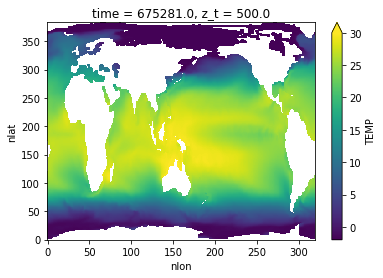

In [21]:
ds.TEMP.isel(z_t=0, time=0).mean('member_id').plot(vmin=-2, vmax=30)

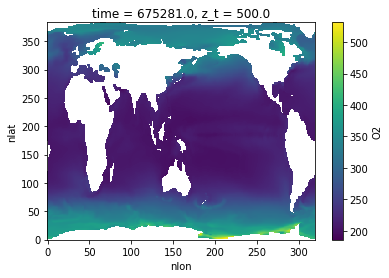

In [24]:
ds.O2.isel(z_t=0, time=0).mean('member_id').plot()

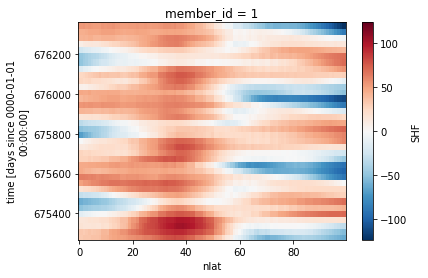

In [22]:
ds.SHF.isel(member_id=0, nlat=slice(150, 250), nlon=slice(150, 250)).mean('nlon').plot()